In [23]:
import numpy as np

import theano
import theano.tensor as T
import lasagne

from tqdm import tqdm, tqdm_notebook

import time
from IPython import display

import matplotlib.pyplot as plt

import networkx as nx

import pandas as pd

from sklearn.mixture import GaussianMixture, GMM

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [21]:
one_hot_X = np.load("../data/LY/LY_one_hot_15.npy").astype(np.int8)
y = np.load("../data/LY/LY_one_hot_15_y.npy").astype(np.int8)

In [24]:
kidera = pd.DataFrame(list(map(lambda x: x.split(","), "A,-1.56,-1.67,-0.97,-0.27,-0.93,-0.78,-0.2,-0.08,0.21,-0.48;R,0.22,1.27,1.37,1.87,-1.7,0.46,0.92,-0.39,0.23,0.93;N,1.14,-0.07,-0.12,0.81,0.18,0.37,-0.09,1.23,1.1,-1.73;D,0.58,-0.22,-1.58,0.81,-0.92,0.15,-1.52,0.47,0.76,0.7;C,0.12,-0.89,0.45,-1.05,-0.71,2.41,1.52,-0.69,1.13,1.1;Q,-0.47,0.24,0.07,1.1,1.1,0.59,0.84,-0.71,-0.03,-2.33;E,-1.45,0.19,-1.61,1.17,-1.31,0.4,0.04,0.38,-0.35,-0.12;G,1.46,-1.96,-0.23,-0.16,0.1,-0.11,1.32,2.36,-1.66,0.46;H,-0.41,0.52,-0.28,0.28,1.61,1.01,-1.85,0.47,1.13,1.63;I,-0.73,-0.16,1.79,-0.77,-0.54,0.03,-0.83,0.51,0.66,-1.78;L,-1.04,0,-0.24,-1.1,-0.55,-2.05,0.96,-0.76,0.45,0.93;K,-0.34,0.82,-0.23,1.7,1.54,-1.62,1.15,-0.08,-0.48,0.6;M,-1.4,0.18,-0.42,-0.73,2,1.52,0.26,0.11,-1.27,0.27;F,-0.21,0.98,-0.36,-1.43,0.22,-0.81,0.67,1.1,1.71,-0.44;P,2.06,-0.33,-1.15,-0.75,0.88,-0.45,0.3,-2.3,0.74,-0.28;S,0.81,-1.08,0.16,0.42,-0.21,-0.43,-1.89,-1.15,-0.97,-0.23;T,0.26,-0.7,1.21,0.63,-0.1,0.21,0.24,-1.15,-0.56,0.19;W,0.3,2.1,-0.72,-1.57,-1.16,0.57,-0.48,-0.4,-2.3,-0.6;Y,1.38,1.48,0.8,-0.56,0,-0.68,-0.31,1.03,-0.05,0.53;V,-0.74,-0.71,2.04,-0.4,0.5,-0.81,-1.07,0.06,-0.46,0.65".split(";"))), index=["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"], columns=["aminoacid"] + list(map(lambda x: "f"+str(x), range(1,11))))

In [3]:
# one_hot_X = np.load("../data/mnist_test_X.npy")
# y = np.load("../data/mnist_test_Y.npy")

In [25]:
one_hot_X = one_hot_X.reshape(-1, 15, 20)

In [36]:
kidera_values = kidera[kidera.columns[1:]].values

In [48]:
#def one_hot_to_emb(X):

emb_X = np.zeros((one_hot_X.shape[0], 15, 10))

for i, x in tqdm_notebook(enumerate(one_hot_X)):
    where = np.where(x)
    for x_pos, y_pos in zip(where[0], where[1]):
        
        emb_X[i, x_pos, :] = kidera_values[y_pos]
    

A Jupyter Widget

In [63]:
emb_X = emb_X.transpose([0,2,1])
emb_X.shape

(622947, 10, 15)

In [64]:
train_X, test_X, train_y,  test_y = train_test_split(emb_X, y)


In [ ]:
#FC net overfits

input_X = T.matrix("X")
input_shape = [None,300]

vl_input = lasagne.layers.InputLayer(input_shape)

dense_1 = lasagne.layers.DenseLayer(vl_input, 300, nonlinearity=lasagne.nonlinearities.rectify)
dense_2 = lasagne.layers.DenseLayer(dense_1, 300, nonlinearity=lasagne.nonlinearities.rectify)
dense_3 = lasagne.layers.DenseLayer(dense_2, 300, nonlinearity=lasagne.nonlinearities.rectify)
vl_output = lasagne.layers.DenseLayer(dense_3, 1, nonlinearity=lasagne.nonlinearities.sigmoid)

In [85]:
input_X = T.tensor3("X")
input_shape = [None,10,15]

vl_input = lasagne.layers.InputLayer(input_shape)

vl_conv_1 = lasagne.layers.Conv1DLayer(vl_input, num_filters=20, filter_size=5, stride = 1, pad = 2)
#vl_pool_1 = lasagne.layers.MaxPool1DLayer(vl_conv_1, 2)

vl_conv_2 = lasagne.layers.Conv1DLayer(vl_conv_1, 40, 5, stride = 1, pad = 2)
#vl_pool_2 = lasagne.layers.Pool1DLayer(vl_conv_2, 2)

vl_conv_3 = lasagne.layers.Conv1DLayer(vl_conv_2, 80, 5, stride = 1, pad = 2)
#vl_pool_3 = lasagne.layers.Pool1DLayer(vl_conv_3, 2)

vl_reshape_back = lasagne.layers.FlattenLayer(vl_conv_3)
dense_3 = lasagne.layers.DenseLayer(vl_reshape_back, 400, nonlinearity=lasagne.nonlinearities.rectify)
vl_output = lasagne.layers.DenseLayer(dense_3, 1, nonlinearity=lasagne.nonlinearities.sigmoid)

In [86]:
sh = (13, 10, 15)
for layer in lasagne.layers.get_all_layers(vl_output):
    
    out_sh = layer.get_output_shape_for(sh)

    print(layer, sh, out_sh)
    
    sh = out_sh

<lasagne.layers.input.InputLayer object at 0x7f18aecfd4a8> (13, 10, 15) (13, 10, 15)
<lasagne.layers.conv.Conv1DLayer object at 0x7f18aecfd4e0> (13, 10, 15) (13, 20, 15)
<lasagne.layers.conv.Conv1DLayer object at 0x7f18aecfdfd0> (13, 20, 15) (13, 40, 15)
<lasagne.layers.conv.Conv1DLayer object at 0x7f18aed00160> (13, 40, 15) (13, 80, 15)
<lasagne.layers.shape.FlattenLayer object at 0x7f18aec5d588> (13, 80, 15) (13, 1200)
<lasagne.layers.dense.DenseLayer object at 0x7f18aec5d668> (13, 1200) (13, 400)
<lasagne.layers.dense.DenseLayer object at 0x7f18aec5d358> (13, 400) (13, 1)


In [87]:
target = T.vector()

In [88]:
# create prediction variable
v_prediction = lasagne.layers.get_output(vl_output, inputs = input_X, deterministic=True)
# create loss function
v_loss = lasagne.objectives.binary_crossentropy(v_prediction, target).mean()

# create parameter update expressions
v_params = lasagne.layers.get_all_params(vl_output, trainable = True)
lr = theano.shared(0.01)
v_updates = lasagne.updates.adam(v_loss, v_params, learning_rate=lr, beta2=0.98)

# compile training and testing functions
v_train_fn = theano.function([input_X, target], v_loss, updates = v_updates)
v_test_fn = theano.function([input_X], v_prediction)
v_test_loss_fn = theano.function([input_X, target], v_loss)

In [72]:
def iterate_minibatches(inputs, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], y[excerpt]

In [89]:
epochs = 20
v_losses_train = []
all_losses = []
v_logloss = []
v_losses_valid = []
#val_batches = 500
batch_size = 400
print_interval = 20

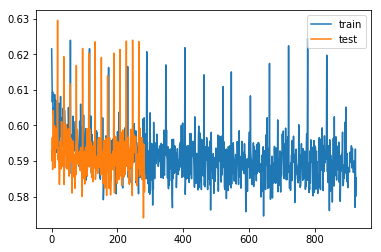

KeyboardInterrupt: 

In [102]:
for epoch in range(epochs):
    ls_tr = 0.
    ls_val = 0.
    logloss_tr = 0.
    for i, (batch_x, batch_y) in tqdm_notebook(enumerate(iterate_minibatches(train_X, train_y, batch_size))):
        curr_loss = v_train_fn(batch_x, batch_y)
        ls_tr += curr_loss
        
        if i % print_interval == 0 and i > 0:
            all_losses.append(ls_tr / print_interval)
            ls_tr = 0
            
            display.clear_output(wait=True)
            plt.plot(all_losses[1:], label='train')
            plt.plot(v_losses_valid[1:], label='test')
            plt.legend()
            plt.show()
        
    v_losses_train.append(ls_tr/ i)
    
    for i, (batch_x, batch_y) in enumerate(iterate_minibatches(test_X,test_y, batch_size)):
        ls_val += v_test_loss_fn(batch_x, batch_y)
        
        
        if i % print_interval == 0 and i != 0 :
            v_losses_valid.append(ls_val / print_interval)
            ls_val = 0
            display.clear_output(wait=True)
            plt.plot(all_losses[1:], label='train')
            plt.plot(v_losses_valid[1:], label='test')
            plt.legend()
            plt.show()
            
    #lr = lr * 0.98
        
    #tqdm.write(str(ls_val / i))
    
    

In [93]:
lr = 

array(0.00833748)

In [ ]:
test_y[:10].shape

In [ ]:
v_test_loss_fn(test_X[:10000], test_y[:10000])

In [ ]:
for batch_x, batch_y in iterate_minibatches(test_X[:1000],test_y[:1000], 1000):
    print( v_test_loss_fn(batch_x, batch_y))
    

In [103]:
pred = v_prediction.eval({input_X : test_X[:40]})

In [78]:
pred_train = v_prediction.eval({input_X : train_X[:200]})

In [104]:
(pred.reshape(-1))[:]

array([0.24417832, 0.14624386, 0.324189  , 0.10277796, 0.1590145 ,
       0.40386752, 0.42674074, 0.26479691, 0.48014628, 0.37245137,
       0.22561598, 0.30465762, 0.23322755, 0.25632186, 0.2268983 ,
       0.24953447, 0.06602352, 0.1756705 , 0.38152281, 0.41893847,
       0.3655147 , 0.06785789, 0.39970267, 0.36263907, 0.36462282,
       0.3742513 , 0.32495071, 0.25239156, 0.37425188, 0.14226914,
       0.22002152, 0.0873168 , 0.20243637, 0.14262707, 0.32840098,
       0.23544537, 0.4793802 , 0.33565448, 0.54876902, 0.17097318])

In [105]:
test_y[:40]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int8)

In [83]:
pred_train[:20].reshape(-1)

array([0.20658608, 0.45276935, 0.31456697, 0.4226934 , 0.28295978,
       0.20460851, 0.32935463, 0.24531031, 0.30916384, 0.36586196,
       0.45020717, 0.20100626, 0.50296292, 0.12402872, 0.22737628,
       0.39674183, 0.51186883, 0.23529346, 0.27751019, 0.36974411])

In [84]:
train_y[:20]

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0],
      dtype=int8)

In [96]:
test_y[:20]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
      dtype=int8)

In [106]:
f1_score(test_y[:40], pred > 0.5)

0.0

In [ ]:
f1_score(train_y[:200], pred_train > 0.5)